##Create virtual Enviroment


In [ ]:
!apt install python3.10-venv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-pip-whl python3-setuptools-whl
The following NEW packages will be installed:
  python3-pip-whl python3-setuptools-whl python3.10-venv
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 2,473 kB of archives.
After this operation, 2,882 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-pip-whl all 22.0.2+dfsg-1ubuntu0.3 [1,679 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-setuptools-whl all 59.6.0-1.2ubuntu0.22.04.1 [788 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3.10-venv amd64 3.10.12-1~22.04.2 [5,724 B]
Fetched 2,473 kB in 1s (3,566 kB/s)
Selecting previously unselected package python3-pip-whl.
(Reading database ... 120874 files and directories currently installed.)
Pr

In [ ]:
!python -m venv myenv

In [ ]:
!source myenv/bin/activate

##Importing the images and splitting it into train,test.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2

###Importing the training dataset

In [ ]:
train_dataset = r'/content/drive/MyDrive/COVID 19/Train'
categories = ['Lungs Disease','Normal',]
data_1 =[]
IMZ_SIZE = 180
for category in categories:
  folder_1 = os.path.join(train_dataset,category)
  label_1 = categories.index(category)
  for imz in os.listdir(folder_1):
    imz_join = os.path.join(folder_1,imz)
    imz_read = cv2.imread(imz_join)
    imz_resize = cv2.resize(imz_read,(IMZ_SIZE,IMZ_SIZE))
    data_1.append([imz_resize,label_1])


###Importing the Test dataset

In [ ]:
test_dataset = r'/content/drive/MyDrive/COVID 19/Test'
data_2 = []
for category in categories:
  folder_2 = os.path.join(test_dataset,category)
  label_2 = categories.index(category)
  for imz_1 in os.listdir(folder_2):
    imz_join2 = os.path.join(folder_2,imz_1)
    imz_read2 = cv2.imread(imz_join2)
    imz_resize1 = cv2.resize(imz_read2,(IMZ_SIZE,IMZ_SIZE))
    data_2.append([imz_resize1,label_2])


###Extracting features and labels from training dataset.

In [ ]:
#for training data
import random
random.shuffle(data_1)

In [ ]:
import numpy as np
X_train = []
Y_train = []
for features,labels in data_1:
  X_train.append(features)
  Y_train.append(labels)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [ ]:
Y_train_reshape = Y_train.reshape(len(Y_train),1*1)
Y_train_reshape[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]])

In [ ]:
#Changing to categorical as we want to use categorical crossentropy
Y_train_categorical = keras.utils.to_categorical(Y_train_reshape,num_classes=2,dtype='float32')
Y_train_categorical[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

###Extracting features and labels from test dataset

In [ ]:
random.shuffle(data_2)

In [ ]:
X_test = []
Y_test = []
for features,labels in data_2:
  X_test.append(features)
  Y_test.append(labels)
X_test = np.array(X_test)
Y_test = np.array(Y_test)


In [ ]:
Y_test_reshape = Y_test.reshape(len(Y_test),1*1)
Y_test_categorical = keras.utils.to_categorical(Y_test_reshape,num_classes=2,dtype='float32')


##Transfer Learning.
####By using ResNet50 model

In [ ]:
from keras.applications.resnet50 import ResNet50

In [ ]:
conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(180,180,3)
)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 186, 186, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 90, 90, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 90, 90, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

##Building the Dense layer

In [ ]:
model = keras.Sequential([
      conv_base,
      keras.layers.Flatten(),
      keras.layers.Dense(500,activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(300,activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(200,activation='relu'),
      keras.layers.Dense(2,activation='softmax'),
])




In [ ]:
conv_base.trainable='False'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

##Data Argumentation


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
)

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/COVID 19/Train',
    target_size=(180,180),
    batch_size=5,
    class_mode='categorical',
)

Found 12816 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/COVID 19/Test',
    target_size=(180,180),
    batch_size=5,
    class_mode='categorical',
)

Found 3388 images belonging to 2 classes.


###Plotting the info regarding Dense layer.

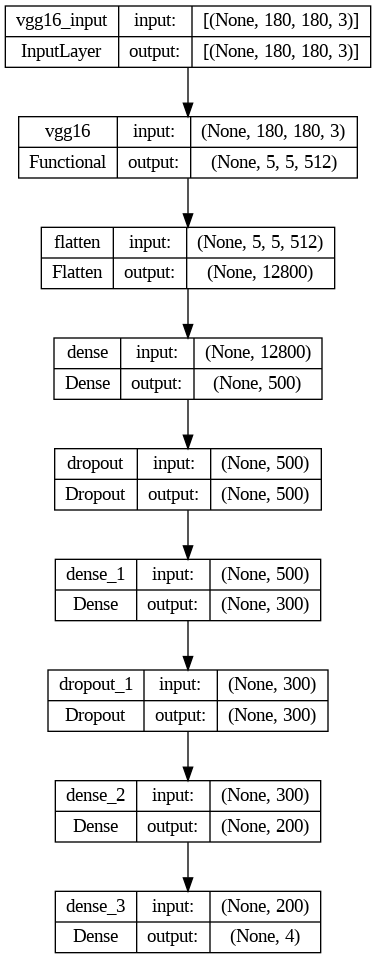

In [ ]:
plot_model(model,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
visualkeras.layered_view(model)

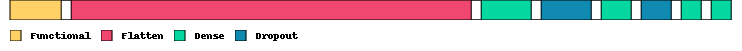

In [ ]:
visualkeras.layered_view(model,legend=True,draw_volume=False)

###Do not train the vgg16 model, because the best accuracy that we will get is already stored in the weights of VGG16 model.

In [ ]:
conv_base.trainable=False

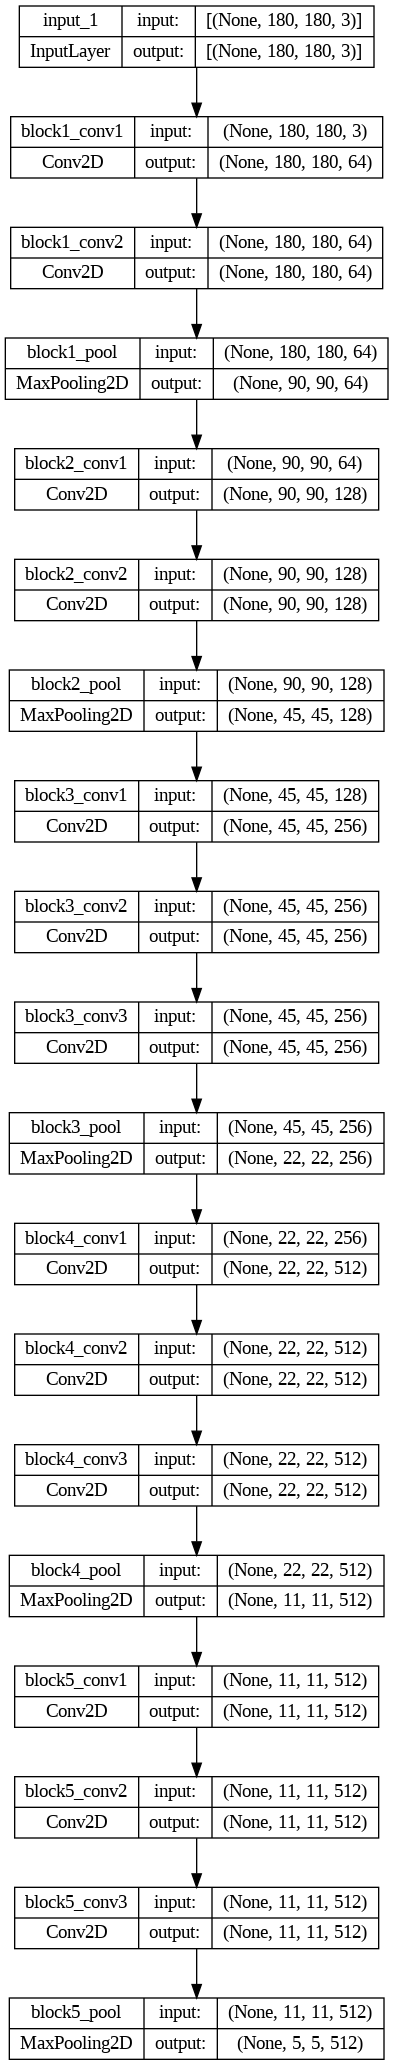

In [ ]:
plot_model(conv_base,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_generator,validation_data=test_generator,epochs=25)

Epoch 1/25
 100/2564 [>.............................] - ETA: 2:31:24 - loss: 4.8037 - accuracy: 0.5980

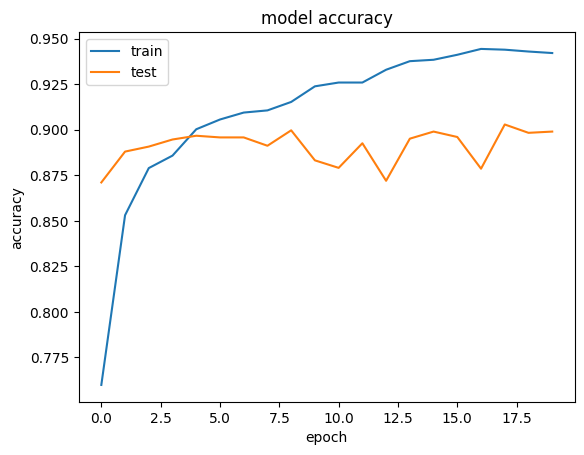

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

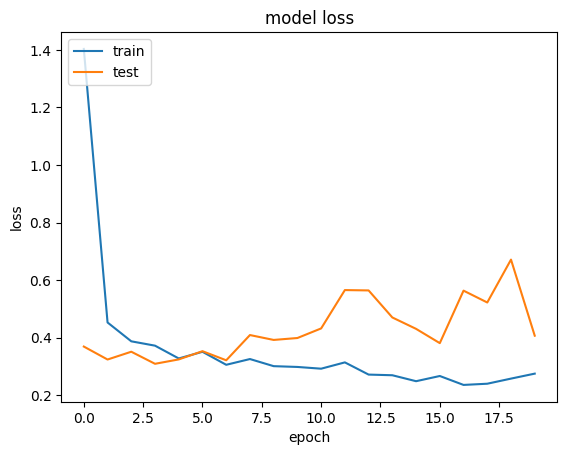

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
input_image = input('Enter the path of image:')
input_path = cv2.imread(input_image)
input_resize = cv2.resize(input_path,(180,180))
input_reshape = input_resize.reshape(1,180,180,3)
print(categories[np.argmax(model.predict(input_reshape))])



Enter the path of image:/content/drive/MyDrive/testing/D5.jpg
1/1 [==============================] - 0s 18ms/step
Lungs Disease


In [ ]:
#saving the model
model.save('/content/drive/MyDrive/saved model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
